In this notebook, we experiment with a binary classification for the ending sentence for stories using our text classification model we developed in HW4, thhis time with the pretrained GLOVE embeddings

In [16]:
#imports
import pandas as pd
from collections import Counter, defaultdict
import torch
import torch.utils.data
import numpy as np
import string
from nltk import word_tokenize
from sklearn.metrics import accuracy_score

print("Cuda available:", torch.cuda.is_available())

Cuda available: True


In [17]:
#load the datasets
data_train_raw = pd.read_csv("ROCStories_winter2017.csv")
data_test_raw = pd.read_csv("cloze_test_2016.csv")
data_val_raw = pd.read_csv("cloze_val_2016.csv")


#test set 
endings = data_test_raw.RandomFifthSentenceQuiz1.tolist(),data_test_raw.RandomFifthSentenceQuiz2.tolist()
answers =data_test_raw.AnswerRightEnding.tolist()
#seperate the endings for each example into appropriate lists
test_true = []
test_false = []
num_instances , num_columns = data_test_raw.shape
for i in range(num_instances):
    test_true.append(endings[answers[i]-1][i])
    test_false.append(endings[(answers[i]+2)%2][i])
    

# validation set (duplicate code from above, probably couldve just made a function to process the test and
# val sets but oh well)
val_endings = data_val_raw.RandomFifthSentenceQuiz1.tolist(),data_val_raw.RandomFifthSentenceQuiz2.tolist()
val_answers =data_val_raw.AnswerRightEnding.tolist()
#seperate the endings for each example into appropriate lists
val_true = []
val_false = []
num_instances , num_columns = data_val_raw.shape
for i in range(num_instances):
    val_true.append(val_endings[val_answers[i]-1][i])
    val_false.append(val_endings[(val_answers[i]+2)%2][i])
    
#check the first 20 examples in the test and val set to see how it looks
print("**********TEST SET**********\n")
for i in range(20):
    print("TRUE ENDING:\t", test_true[i])
    print("FALSE ENDING:\t", test_false[i])
    print("\n")
    
print("**********VALIDATION SET**********\n")
for i in range(20):
    print("TRUE ENDING:\t", val_true[i])
    print("FALSE ENDING:\t", val_false[i])
    print("\n")
    
#lets create a list of tuples for each of these sets
test_set = []
val_set = []
#test set
for i in range(len(test_true)):
    test_set.append((test_true[i], 'Coherent'))
for i in range(len(test_false)):
    test_set.append((test_false[i], 'Incoherent'))
#val set
for i in range(len(val_true)):
    val_set.append((val_true[i], 'Coherent'))
for i in range(len(val_false)):
    val_set.append((val_false[i], 'Incoherent'))
    


**********TEST SET**********

TRUE ENDING:	 The next weekend, I was asked to please stay home.
FALSE ENDING:	 My friends decided to keep inviting me out as I am so much fun.


TRUE ENDING:	 My allergies were too bad and I had to go back home.
FALSE ENDING:	 It reminded me of how much I loved spring flowers.


TRUE ENDING:	 Avery regretted what she did the next day.
FALSE ENDING:	 Avery thought her children would be happy with her decision.


TRUE ENDING:	 Josh got sick.
FALSE ENDING:	 Josh thought that the pie was delicious.


TRUE ENDING:	 He felt inspiration and then went back home to write.
FALSE ENDING:	 John then got an idea for his painting.


TRUE ENDING:	 The cashier handed them the cash so they would go away.
FALSE ENDING:	 The cashier invited the men to her high school reunion.


TRUE ENDING:	 They called the police to come to my house.
FALSE ENDING:	 They liked me a lot after that.


TRUE ENDING:	 Kerry was so grateful!
FALSE ENDING:	 Kerry was disappointed.


TRUE ENDING:	 

In [18]:
#Vocabulary class courtesy of HW4

class MyVocabulary:
    def __init__(self, special_tokens=None):
        self.w2idx = {}
        self.idx2w = {}
        self.w2cnt = defaultdict(int)
        self.special_tokens = special_tokens
        if self.special_tokens is not None:
            self.add_tokens(special_tokens)

    def add_tokens(self, tokens):
        for token in tokens:
            self.add_token(token)
            self.w2cnt[token] += 1

    def add_token(self, token):
        if token not in self.w2idx:
            cur_len = len(self)
            self.w2idx[token] = cur_len
            self.idx2w[cur_len] = token

    def prune(self, min_cnt=2):
        to_remove = set([token for token in self.w2idx if self.w2cnt[token] < min_cnt])
        #print(set(self.special_tokens))
        
        #INSERTED THESE CHANGES MYSELF
        for token in self.special_tokens:
            if token in to_remove:
                to_remove.remove(token)
        #THE ORIGINAL CODE IN PRUNE WAS REMOVING <PAD> FROM THE VOCAB
        #to_remove ^= set(self.special_tokens)
        #print('<PAD>' in to_remove,self.w2cnt['<PAD>'])

        for token in to_remove:
            self.w2cnt.pop(token)

        self.w2idx = {token: idx for idx, token in enumerate(self.w2cnt.keys())}
        self.idx2w = {idx: token for token, idx in self.w2idx.items()}
        
        #print("Pad in w2cnt", '<PAD>' in self.w2cnt)
        #print("Pad in w2idx", '<PAD>' in self.w2idx)
        #print("Pad in idx2w", self.idx2w[0] is '<PAD>')
        #print(self.w2idx['<PAD>'])

    def __contains__(self, item):
        return item in self.w2idx

    def __getitem__(self, item):
        if isinstance(item, str):
            return self.w2idx[item]
        elif isinstance(item , int):
            return self.idx2w[item]
        else:
            raise TypeError("Supported indices are int and str")

    def __len__(self):
        return(len(self.w2idx))

In [19]:
#Text classification dataset from HW4
#manually set max length of sentence to 13. arbitrarily chosen number

class TextClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, vocab=None, labels_vocab=None, max_len=13, lowercase=True):
        """
        Args:
            texts (list of str): texts of the dataset examples
            labels (list of str): the correponding labels of the dataset examples
            vocab (MyVocabulary, optional): vocabular to convert text to indices. If not provided, will be created based on the texts
            labels_vocab (MyVocabulary, optional): vocabular to convert labels to indices. If not provided, will be created based on the labels
            max_len (int): maximum length of the text. Texts shorter than max_len will be cut at the end
            lowercase (bool, optional): a fag specifying whether or not the input text should be lowercased
        """
        
        self.max_len = max_len
        self.lowercase = lowercase
        

        self.texts = [self._preprocess(t, max_len=max_len, lowercase=lowercase) for t in texts]
        self.labels = labels

        if vocab is None:
            vocab = MyVocabulary(['<PAD>', '<UNK>'])
            for text in self.texts:
                vocab.add_tokens(text)
            
        if labels_vocab is None:
            labels_vocab = MyVocabulary()
            labels_vocab.add_tokens(labels)
            
        self.vocab = vocab
        self.labels_vocab = labels_vocab
        
    def _preprocess(self, text, max_len=None, lowercase=True):
        """
        Preprocess a give dataset example
        Args:
            text (str): given dataset example
            max_len (int, optional): maximum sequence length
            lowercase (bool, optional): a fag specifying whether or not the input text should be lowercased
        
        Returns:
            a list of tokens for a given text span
        """ 
        ### YOUR CODE BELOW ###
        if lowercase:
            text = text.lower()
        # tokenize the input text
       
        tokens = []
        tokens = word_tokenize(text)
        
        # cut the list of tokens to `max_len` if needed 
        if len(tokens) > max_len:
            del tokens[max_len:]
        tokens = self._pad(tokens)
        ### YOUR CODE ABOVE ###
        return tokens
    
    def _pad(self, tokens):
        """
        Pad tokens to self.max_len
        Args:
            tokens (list): a list of str tokens for a given example
            
        Returns:
            list: a padded list of str tokens for a given example
        """
        # pad the list of tokens to be exactly of the `max_len` size
        ### YOUR CODE BELOW ###
        if len(tokens) < self.max_len:
            for i in range(len(tokens), self.max_len):
                tokens.append("<PAD>") 
        ### YOUR CODE ABOVE ###
        return tokens

    def __getitem__(self, idx):
        """
        Given an index, return a formatted dataset example
        
        Args:
            idx (int): dataset index
            
        Returns:
            tuple: a tuple of token_ids based on the vocabulary mapping  and a corresponding label
        """
        ### YOUR CODE BELOW ###
        tokens = []
        words = self.texts[idx]
        for word in words:
            if word not in self.vocab.w2cnt:
                #print(word)
                tokens.append(self.vocab.w2idx['<UNK>'])
            elif word != '<PAD>':
                tokens.append(self.vocab.w2idx[word])
            elif word == '<PAD>':
                tokens.append(self.vocab.w2idx["<PAD>"])
                #print("found pad")
        label = self.labels[idx]
        ### YOUR CODE ABOVE ###
        
        return  np.asarray(tokens), np.asarray(self.labels_vocab.w2idx[label])

    def __len__(self):
        return len(self.texts)

In [20]:
import random
random.shuffle(test_set)
random.shuffle(val_set)


data_train = []
labels_train = []

data_test, labels_test = zip(*test_set)
data_train, labels_train = zip(*val_set)

print(data_train[0],labels_train[0])

Alice messaged a cute guy she saw on Tinder. Incoherent


In [21]:
dataset_train = TextClassificationDataset(data_train, labels_train)
dataset_test = TextClassificationDataset(data_test, labels_test, vocab=dataset_train.vocab, labels_vocab=dataset_train.labels_vocab)

In [22]:
print(len(dataset_train.vocab.w2cnt), "words before pruning")
dataset_train.vocab.prune()
print(len(dataset_train.vocab.w2cnt),"words after pruning")

3880 words before pruning
2110 words after pruning


In [23]:
#Glove embeddings
#initialize model embedding matrix with glove embeddings
embedding_dim = len(dataset_train.vocab)
glove_matrix = torch.nn.Embedding(embedding_dim, 300)

with open("glove.6B.300d.txt", "r") as glove:
    for line in glove:
        if len(line.split()) > 301:
            continue#skip words with spaces
        if line.split()[0] in dataset_train.vocab.w2idx:
            weight = np.array([float(t) for t in line.strip().split()[1:]])
            glove_matrix.weight.data[dataset_train.vocab.w2idx[line.split()[0]]] = torch.FloatTensor(weight)


In [24]:
class TextClassificationModel(torch.nn.Module):
    def __init__(self, embedding_size, vocab_size, hidden_size, nb_classes, pretrained_embeddings):
        super().__init__()
        
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.nb_classes = nb_classes
        
        self.dropout = torch.nn.Dropout(.50)

        ### YOUR CODE BELOW ###
        self.embeddings = pretrained_embeddings
        self.GRU = torch.nn.GRU(embedding_size, hidden_size, batch_first = True)
        self.projection = torch.nn.Linear(hidden_size, nb_classes)
        ### YOUR CODE ABOVE ###
        
        
    def forward(self, inputs):
        ### YOUR CODE BELOW ###
        embeds = self.embeddings(inputs)
        embeds = self.dropout(embeds)
        outputs, garbage = self.GRU(embeds)
        outputs = torch.max(outputs, dim = 1)[0]
        logits = self.projection(outputs)
        ### YOUR CODE ABOVE ###        
        
        return logits

In [25]:
# DATALOADER #
dataloader_train = torch.utils.data.DataLoader(dataset_train, shuffle=True, batch_size=64)
dataloader_test = torch.utils.data.DataLoader(dataset_test, shuffle=False, batch_size=64)

# MODEL INITIALIZATION #
model = TextClassificationModel(300, len(dataset_train.vocab), 128, 2, glove_matrix)#2 labels
if torch.cuda.is_available():
    model = model.cuda()
# OPTIMIZER #
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# LOSS-FUNCTION #
criterion = torch.nn.CrossEntropyLoss()

In [26]:
# TRAINING #
losses = []
for epoch in range(10):
    epoch_losses = []
    for i, batch in enumerate(dataloader_train):
        optimizer.zero_grad()
        
        x, y = batch
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()
        
        #print(y)
        logits = model(x)
        loss = criterion(logits, y)
        
        epoch_losses.append(loss.item())
        
        loss.backward()
        optimizer.step()

    epoch_loss = np.mean(epoch_losses)
    losses.append(epoch_loss)
    print('Epoch {}, loss {}'.format(epoch, epoch_loss))

Epoch 0, loss 0.6916549316907333
Epoch 1, loss 0.6709514452239215
Epoch 2, loss 0.6373017086821088
Epoch 3, loss 0.6130113136970391
Epoch 4, loss 0.5788568025928432
Epoch 5, loss 0.5405828882071931
Epoch 6, loss 0.5238802241066755
Epoch 7, loss 0.4916328888828472
Epoch 8, loss 0.4725916663468894
Epoch 9, loss 0.4424844303373563


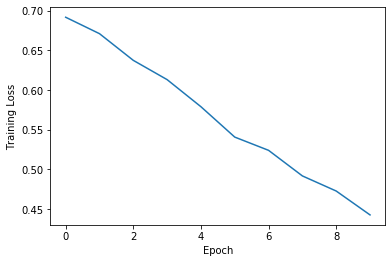

In [27]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.show()

In [28]:
def predict(model, dataloader):
    """
    Predict probability distributions over classes on the test data
    
    Args:
        model: your torch.nn.Module() model object
        dataloader: test Dataloder() object
        
    Returns:
        tuple: np.array/list with true labels and np.array/list with predicted labels
    """
    y_pred = []
    y_true = []
    
    ### YOUR CODE BELOW ###
    for i, batch in enumerate(dataloader):
        x, y = batch
        
        if torch.cuda.is_available():
            x = x.cuda()
            
        outputs = model(x).detach().cpu()
        y_pred.append(torch.argmax(outputs.data, 1))
        y_true.append(y)
        
    ### YOUR CODE ABOVE ###
        
    y_pred = np.concatenate(y_pred, axis=0)
    y_true = np.concatenate(y_true, axis=0)    
    
    return y_true, y_pred

In [29]:
y_true_train, y_pred_train = predict(model, dataloader_train)
y_true_test, y_pred_test = predict(model, dataloader_test)

In [30]:
### YOUR CODE BELOW ###
acc_train = accuracy_score(y_true_train, y_pred_train)
acc_test = accuracy_score(y_true_test, y_pred_test)
### YOUR CODE ABOVE ###

print('Accuracy train', acc_train)
print('Accuracy test', acc_test)

Accuracy train 0.8156066274719401
Accuracy test 0.6349545697487974
